In [ ]:
!pip install librosa soundfile tqdm -q

import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os
import shutil
from pathlib import Path
from tqdm import tqdm
import json
import tarfile
import requests
from google.colab import drive
from scipy.signal import butter, lfilter
import pickle

In [ ]:
print("📂 Mounting Google Drive...")
drive.mount('/content/drive')

📂 Mounting Google Drive...
Mounted at /content/drive


In [ ]:
DRIVE_OUTPUT = '/content/drive/MyDrive/InstruNet_Data'
os.makedirs(DRIVE_OUTPUT, exist_ok=True)
print(f"✅ Will save processed data to: {DRIVE_OUTPUT}")

✅ Will save processed data to: /content/drive/MyDrive/InstruNet_Data


In [ ]:
# PART 2: DATA AUGMENTATION FUNCTIONS (FOR QUALITY/CONDITION LABELS)
# ===================================================================================

def add_white_noise(audio, snr_db):
    """Add white noise at specified SNR level"""
    signal_power = np.mean(audio ** 2)
    noise_power = signal_power / (10 ** (snr_db / 10))
    noise = np.random.normal(0, np.sqrt(noise_power), len(audio))
    return audio + noise

def add_vinyl_artifacts(audio, sr=22050):
    """Simulate vintage vinyl recording with crackle and hiss"""
    # Random pops/crackles
    crackle_prob = 0.0005
    crackle = np.random.binomial(1, crackle_prob, len(audio)) * np.random.uniform(-0.5, 0.5, len(audio))

    # High-frequency hiss
    hiss = np.random.normal(0, 0.015, len(audio))
    b, a = butter(4, 3000 / (sr / 2), btype='high')
    hiss = lfilter(b, a, hiss)

    return audio + crackle + hiss * 0.8

def simulate_old_equipment(audio, sr=22050):
    """Simulate limited bandwidth of old recording equipment"""
    # Band-pass filter: 200 Hz - 4000 Hz (typical old equipment)
    nyquist = sr / 2
    low = 200 / nyquist
    high = 4000 / nyquist
    b, a = butter(4, [low, high], btype='band')
    filtered = lfilter(b, a, audio)

    # Add vintage artifacts
    return add_vinyl_artifacts(filtered, sr)

def add_compression_artifacts(audio):
    """Simulate low bitrate compression"""
    # Quantization to simulate low bitrate
    max_val = 2 ** 6  # 6-bit quantization
    quantized = np.round(audio * max_val) / max_val
    return np.clip(quantized, -1, 1)

def create_augmented_variants(audio, sr=22050):
    """
    Create 4 variants from original audio:
    1. Excellent - Original (modern, clean)
    2. Good - Light noise (modern, noisy)
    3. Fair - Heavy noise (clean but degraded)
    4. Poor - Vintage/old (vintage with artifacts)
    """
    return {
        'excellent': {
            'audio': audio,
            'quality': 'excellent',  # 0
            'condition': 'modern'     # 0
        },
        'good': {
            'audio': add_white_noise(audio, snr_db=18),
            'quality': 'good',        # 1
            'condition': 'noisy'      # 2
        },
        'fair': {
            'audio': add_white_noise(audio, snr_db=10),
            'quality': 'fair',        # 2
            'condition': 'noisy'      # 2
        },
        'poor': {
            'audio': simulate_old_equipment(audio, sr),
            'quality': 'poor',        # 3
            'condition': 'vintage'    # 3
        }
    }


In [ ]:
# ===================================================================================
# PART 3: DOWNLOAD & PROCESS NSYNTH DATASET
# ===================================================================================

def download_nsynth_train():
    """Download NSynth training set (will be deleted after processing)"""
    url = "http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-train.jsonwav.tar.gz"
    output_file = "/content/nsynth-train.jsonwav.tar.gz"
    extract_dir = "/content/nsynth-train"

    if os.path.exists(extract_dir):
        print(f"NSynth already exists at: {extract_dir}")
        return extract_dir

    print("Downloading NSynth Dataset (22 GB)...")
    print(" This will take 2-5 minutes...")

    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))

    with open(output_file, 'wb') as f, tqdm(
        desc="Downloading",
        total=total_size,
        unit='B',
        unit_scale=True,
        unit_divisor=1024,
    ) as pbar:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
            pbar.update(len(chunk))

    print(" Download complete!")

    print("\n Extracting archive...")
    with tarfile.open(output_file, 'r:gz') as tar:
        tar.extractall(path="/content")

    print(f" Extracted to: {extract_dir}")

    # Delete archive immediately
    os.remove(output_file)
    print("  Deleted archive (freed ~22 GB)")

    return extract_dir

def load_nsynth_metadata(dataset_dir):
    """Load NSynth metadata"""
    json_path = os.path.join(dataset_dir, "examples.json")
    print(f"\n📋 Loading metadata from: {json_path}")

    with open(json_path, 'r') as f:
        metadata = json.load(f)

    print(f"✅ Loaded metadata for {len(metadata)} audio files")
    return metadata

def filter_acoustic_instruments(metadata, target_instruments=None, min_samples=500):
    """Filter for acoustic instruments only"""
    if target_instruments is None:
        target_instruments = ['brass', 'flute', 'guitar', 'keyboard',
                             'mallet', 'reed', 'string', 'vocal']

    print(f"\n🔍 Filtering acoustic instruments...")
    print(f"📌 Target families: {target_instruments}")
    print(f"⚖️  Minimum samples: {min_samples}")

    filtered_files = {inst: [] for inst in target_instruments}

    for file_id, info in tqdm(metadata.items(), desc="Filtering"):
        if info.get('instrument_source', -1) == 0:  # Acoustic only
            family = info.get('instrument_family_str', '')
            if family in target_instruments:
                filtered_files[family].append(file_id)

    # Balance classes
    print(f"\n📊 Initial Statistics:")
    balanced_files = {}
    for instrument, files in filtered_files.items():
        count = len(files)
        print(f"  {instrument:12s}: {count:5d} files")
        if count >= min_samples:
            balanced_files[instrument] = files
            print(f"KEPT")
        else:
            print(f"    ❌ REMOVED (too few)")

    total = sum(len(files) for files in balanced_files.values())
    print(f"\n✅ Total balanced files: {total}")

    return balanced_files

In [ ]:
# ===================================================================================
# PART 4: FEATURE EXTRACTION
# ===================================================================================

def standardize_audio(file_path, target_sr=22050, duration=3.0):
    """Load and standardize audio to fixed duration"""
    try:
        y, sr = librosa.load(file_path, sr=target_sr, mono=True)
        target_length = int(target_sr * duration)

        if len(y) < target_length:
            y = np.pad(y, (0, target_length - len(y)), mode='constant')
        else:
            y = y[:target_length]

        return y, sr
    except Exception as e:
        print(f"⚠️  Error loading {file_path}: {e}")
        return None, None

def extract_mel_spectrogram(y, sr, n_mels=128, n_fft=2048, hop_length=512):
    """Convert audio to Mel-Spectrogram (128x128)"""
    mel_spec = librosa.feature.melspectrogram(
        y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length
    )

    # Convert to dB
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Normalize to [0, 1]
    mel_spec_norm = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min() + 1e-8)

    # Trim/pad to exactly 128x128
    if mel_spec_norm.shape[1] > 128:
        mel_spec_norm = mel_spec_norm[:, :128]
    elif mel_spec_norm.shape[1] < 128:
        pad_width = 128 - mel_spec_norm.shape[1]
        mel_spec_norm = np.pad(mel_spec_norm, ((0, 0), (0, pad_width)), mode='constant')

    return mel_spec_norm

In [ ]:
def process_with_augmentation(dataset_dir, filtered_files, max_per_class=1000):
    print("🎵 PROCESSING MULTI-TASK DATASET")
    audio_dir = os.path.join(dataset_dir, "audio")

    # Encoders
    quality_map = {'excellent': 0, 'good': 1, 'fair': 2, 'poor': 3}
    condition_map = {'modern': 0, 'clean': 1, 'noisy': 2, 'vintage': 3}

    all_X = []
    all_y_instrument = []
    all_y_quality = []
    all_y_condition = []

    for instrument, file_ids in filtered_files.items():
        # Limit samples
        if len(file_ids) > max_per_class:
           file_ids = np.random.choice(file_ids, max_per_class, replace=False)  # ← RANDOM SAMPLING
        print(f"\n Processing {instrument}: {len(file_ids)} files → {len(file_ids) * 4} samples")

        for file_id in tqdm(file_ids, desc=f"  {instrument}"):
            file_path = os.path.join(audio_dir, f"{file_id}.wav")

            if not os.path.exists(file_path):
                continue

            # Load original audio
            y, sr = standardize_audio(file_path)
            if y is None:
                continue

            # Create 4 augmented variants
            variants = create_augmented_variants(y, sr)

            for variant_name, variant_data in variants.items():
                # Extract mel-spectrogram
                mel_spec = extract_mel_spectrogram(variant_data['audio'], sr)

                # Append data
                all_X.append(mel_spec)
                all_y_instrument.append(instrument)
                all_y_quality.append(quality_map[variant_data['quality']])
                all_y_condition.append(condition_map[variant_data['condition']])

    # Convert to numpy arrays
    X_data = np.array(all_X)
    y_instrument = np.array(all_y_instrument)
    y_quality = np.array(all_y_quality)
    y_condition = np.array(all_y_condition)

    print(f"\n📊 Final Dataset:")
    print(f"  Total samples: {len(X_data)}")
    print(f"  Shape: {X_data.shape}")
    print(f"  Memory: ~{X_data.nbytes / (1024**3):.2f} GB")

    return X_data, y_instrument, y_quality, y_condition

In [ ]:
# ===================================================================================
# PART 6: SAVE TO DRIVE & CLEANUP
# ===================================================================================

def save_processed_data(drive_output, X, y_inst, y_qual, y_cond):
    """Save all processed data to Google Drive"""
    print(f"\n💾 Saving to Google Drive...")

    np.save(os.path.join(drive_output, 'X_data.npy'), X)
    np.save(os.path.join(drive_output, 'y_instrument.npy'), y_inst)
    np.save(os.path.join(drive_output, 'y_quality.npy'), y_qual)
    np.save(os.path.join(drive_output, 'y_condition.npy'), y_cond)

    # Save label info
    label_info = {
        'instruments': list(np.unique(y_inst)),
        'quality_labels': ['excellent', 'good', 'fair', 'poor'],
        'condition_labels': ['modern', 'clean', 'noisy', 'vintage'],
        'total_samples': len(X),
        'augmentation_factor': 4
    }

    with open(os.path.join(drive_output, 'label_info.json'), 'w') as f:
        json.dump(label_info, f, indent=2)

    print(f" Saved to: {drive_output}")
    print(f"   - X_data.npy: {X.shape}")
    print(f"   - y_instrument.npy: {y_inst.shape}")
    print(f"   - y_quality.npy: {y_qual.shape}")
    print(f"   - y_condition.npy: {y_cond.shape}")

def cleanup_nsynth(dataset_dir):
    """Delete raw NSynth data to free space"""
    if os.path.exists(dataset_dir):
        print(f"\nDeleting raw NSynth data: {dataset_dir}")
        shutil.rmtree(dataset_dir)
        print(f"Deleted!")
        print(f"Your processed data is safe in Google Drive")

In [ ]:
dataset_dir = download_nsynth_train()

 This will take 2-5 minutes...


Downloading: 100%|██████████| 22.2G/22.2G [05:26<00:00, 73.0MB/s]
/tmp/ipython-input-364760725.py:36: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path="/content")


 Download complete!

 Extracting archive...
 Extracted to: /content/nsynth-train
  Deleted archive (freed ~22 GB)


In [ ]:
metadata = load_nsynth_metadata(dataset_dir)
filtered_files = filter_acoustic_instruments(metadata, min_samples=1000)


📋 Loading metadata from: /content/nsynth-train/examples.json
✅ Loaded metadata for 289205 audio files

🔍 Filtering acoustic instruments...
📌 Target families: ['brass', 'flute', 'guitar', 'keyboard', 'mallet', 'reed', 'string', 'vocal']
⚖️  Minimum samples: 1000


Filtering: 100%|██████████| 289205/289205 [00:00<00:00, 1231535.99it/s]


📊 Initial Statistics:
  brass       : 12605 files
KEPT
  flute       :  6362 files
KEPT
  guitar      : 11380 files
KEPT
  keyboard    :  8068 files
KEPT
  mallet      : 26857 files
KEPT
  reed        : 13307 files
KEPT
  string      : 19390 files
KEPT
  vocal       :  3820 files
KEPT

✅ Total balanced files: 101789


In [ ]:
X_data, y_instrument, y_quality, y_condition = process_with_augmentation(
    dataset_dir,
    filtered_files,
    max_per_class=1000
)


🎵 PROCESSING MULTI-TASK DATASET

 Processing brass: 1000 files → 4000 samples


  brass: 100%|██████████| 1000/1000 [01:21<00:00, 12.30it/s]



 Processing flute: 1000 files → 4000 samples


  flute: 100%|██████████| 1000/1000 [01:08<00:00, 14.68it/s]



 Processing guitar: 1000 files → 4000 samples


  guitar: 100%|██████████| 1000/1000 [01:08<00:00, 14.54it/s]



 Processing keyboard: 1000 files → 4000 samples


  keyboard: 100%|██████████| 1000/1000 [01:07<00:00, 14.81it/s]



 Processing mallet: 1000 files → 4000 samples


  mallet: 100%|██████████| 1000/1000 [01:08<00:00, 14.53it/s]



 Processing reed: 1000 files → 4000 samples


  reed: 100%|██████████| 1000/1000 [01:07<00:00, 14.78it/s]



 Processing string: 1000 files → 4000 samples


  string: 100%|██████████| 1000/1000 [01:06<00:00, 14.96it/s]



 Processing vocal: 1000 files → 4000 samples


  vocal: 100%|██████████| 1000/1000 [01:05<00:00, 15.22it/s]



📊 Final Dataset:
  Total samples: 32000
  Shape: (32000, 128, 128)
  Memory: ~3.91 GB


In [ ]:
save_processed_data(DRIVE_OUTPUT, X_data, y_instrument, y_quality, y_condition)


💾 Saving to Google Drive...
 Saved to: /content/drive/MyDrive/InstruNet_Data
   - X_data.npy: (32000, 128, 128)
   - y_instrument.npy: (32000,)
   - y_quality.npy: (32000,)
   - y_condition.npy: (32000,)


In [ ]:
cleanup_nsynth(dataset_dir)


Deleting raw NSynth data: /content/nsynth-train
Deleted!
Your processed data is safe in Google Drive


In [ ]:
# ===================================================================================
# PART 7: MULTI-TASK CNN MODEL
# ===================================================================================

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def build_multitask_model(input_shape=(128, 128, 1), num_instruments=8):
    """
    Multi-Task CNN:
    - Shared backbone (feature extractor)
    - 3 task-specific heads (instrument, quality, condition)
    """
    # Input
    inputs = layers.Input(shape=input_shape)

    # Shared CNN Backbone
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    # Flatten
    x = layers.Flatten()(x)
    shared = layers.Dense(512, activation='relu')(x)
    shared = layers.Dropout(0.5)(shared)

    # Task 1: Instrument Classification (Primary)
    inst_branch = layers.Dense(256, activation='relu', name='inst_dense')(shared)
    inst_branch = layers.Dropout(0.4)(inst_branch)
    instrument_output = layers.Dense(num_instruments, activation='softmax', name='instrument')(inst_branch)

    # Task 2: Quality Assessment
    qual_branch = layers.Dense(128, activation='relu', name='qual_dense')(shared)
    qual_branch = layers.Dropout(0.3)(qual_branch)
    quality_output = layers.Dense(4, activation='softmax', name='quality')(qual_branch)

    # Task 3: Condition Assessment
    cond_branch = layers.Dense(128, activation='relu', name='cond_dense')(shared)
    cond_branch = layers.Dropout(0.3)(cond_branch)
    condition_output = layers.Dense(4, activation='softmax', name='condition')(cond_branch)

    # Build model
    model = keras.Model(
        inputs=inputs,
        outputs={
            'instrument': instrument_output,
            'quality': quality_output,
            'condition': condition_output
        },
        name='MultiTask_InstruNet'
    )

    return model

In [ ]:
# ===================================================================================
# PART 8: DATA PREPARATION & TRAINING
# ===================================================================================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

def prepare_training_data(X, y_inst, y_qual, y_cond, test_size=0.2):
    """Prepare data for multi-task training"""
    print("\n📊 Preparing training data...")

    # Reshape X for CNN
    X = X.reshape(X.shape[0], 128, 128, 1).astype('float32')

    # Encode instruments
    le_inst = LabelEncoder()
    y_inst_encoded = le_inst.fit_transform(y_inst)
    y_inst_cat = to_categorical(y_inst_encoded)

    # Quality and condition are already encoded
    y_qual_cat = to_categorical(y_qual)
    y_cond_cat = to_categorical(y_cond)

    print(f"✅ Shapes:")
    print(f"   X: {X.shape}")
    print(f"   Instrument: {y_inst_cat.shape}")
    print(f"   Quality: {y_qual_cat.shape}")
    print(f"   Condition: {y_cond_cat.shape}")
    print(f"📋 Instrument classes: {le_inst.classes_}")

    # Split data
    X_train, X_val, y_inst_train, y_inst_val, y_qual_train, y_qual_val, y_cond_train, y_cond_val = train_test_split(
        X, y_inst_cat, y_qual_cat, y_cond_cat,
        test_size=test_size,
        random_state=42,
        stratify=y_inst_encoded
    )

    print(f"\n📊 Split:")
    print(f"   Training: {len(X_train)} samples")
    print(f"   Validation: {len(X_val)} samples")

    return (X_train, X_val,
            y_inst_train, y_inst_val,
            y_qual_train, y_qual_val,
            y_cond_train, y_cond_val,
            le_inst)

def train_multitask_model(model, X_train, X_val, y_inst_train, y_inst_val,
                          y_qual_train, y_qual_val, y_cond_train, y_cond_val,
                          drive_output, epochs=25):
    """Train multi-task model"""

    # Compile
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss={
            'instrument': 'categorical_crossentropy',
            'quality': 'categorical_crossentropy',
            'condition': 'categorical_crossentropy'
        },
        loss_weights={
            'instrument': 1.0,   # Primary task
            'quality': 0.6,      # Secondary
            'condition': 0.6     # Secondary
        },
        metrics={
            'instrument': ['accuracy'],
            'quality': ['accuracy'],
            'condition': ['accuracy']
        }
    )

    # Callbacks
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_instrument_accuracy',
            patience=5,
            restore_best_weights=True,
            verbose=1,
            mode='max'  # ← ADDED: Maximize accuracy
        ),
        keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(drive_output, 'best_multitask_model.keras'),
            monitor='val_instrument_accuracy',
            save_best_only=True,
            verbose=1,
            mode='max'  # ← ADDED: Save best (highest) accuracy
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-7,
            verbose=1
        )
    ]

    print("\n" + "="*80)
    print("🚀 TRAINING MULTI-TASK MODEL")
    print("="*80)

    # Train
    history = model.fit(
        X_train,
        {
            'instrument': y_inst_train,
            'quality': y_qual_train,
            'condition': y_cond_train
        },
        validation_data=(
            X_val,
            {
                'instrument': y_inst_val,
                'quality': y_qual_val,
                'condition': y_cond_val
            }
        ),
        epochs=epochs,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )

    print("\n✅ Training complete!")

    return history

In [ ]:
X_data = np.load(os.path.join(DRIVE_OUTPUT, "X_data.npy"))

y_instrument = np.load(os.path.join(DRIVE_OUTPUT, "y_instrument.npy"))
y_quality = np.load(os.path.join(DRIVE_OUTPUT, "y_quality.npy"))
y_condition = np.load(os.path.join(DRIVE_OUTPUT, "y_condition.npy"))

with open(os.path.join(DRIVE_OUTPUT, "label_encoder.pkl"), "rb") as f:
    le_inst = pickle.load(f)

with open(os.path.join(DRIVE_OUTPUT, "label_info.json"), "r") as f:
    label_info = json.load(f)

print("✅ Data loaded successfully")
print("X shape:", X_data.shape)
print("Instrument labels:", y_instrument.shape)
print("Quality labels:", y_quality.shape)
print("Condition labels:", y_condition.shape)


✅ Data loaded successfully
X shape: (32000, 128, 128)
Instrument labels: (32000,)
Quality labels: (32000,)
Condition labels: (32000,)


In [ ]:
(X_train, X_val,
 y_inst_train, y_inst_val,
 y_qual_train, y_qual_val,
 y_cond_train, y_cond_val,
 le_inst) = prepare_training_data(X_data, y_instrument, y_quality, y_condition)


📊 Preparing training data...
✅ Shapes:
   X: (32000, 128, 128, 1)
   Instrument: (32000, 8)
   Quality: (32000, 4)
   Condition: (32000, 4)
📋 Instrument classes: ['brass' 'flute' 'guitar' 'keyboard' 'mallet' 'reed' 'string' 'vocal']

📊 Split:
   Training: 25600 samples
   Validation: 6400 samples


In [ ]:
with open(os.path.join(DRIVE_OUTPUT, 'label_encoder.pkl'), 'wb') as f:
    pickle.dump(le_inst, f)
print(f"✅ Label encoder saved")

✅ Label encoder saved


In [ ]:
model = build_multitask_model(num_instruments=len(le_inst.classes_))
print("\n📐 Model Architecture:")
model.summary()


📐 Model Architecture:


Model: "MultiTask_InstruNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        128 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ max_pooling2d_1[… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     73,856 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ max_pooling2d_2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │    295,168 │ dropout_2[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 256) │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 256) │      1,024 │ max_pooling2d_3[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 8, 8, 256) │          0 │ batch_normalizat

 Total params: 9,044,624 (34.50 MB)

 Trainable params: 9,043,664 (34.50 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
history = train_multitask_model(
    model, X_train, X_val,
    y_inst_train, y_inst_val,
    y_qual_train, y_qual_val,
    y_cond_train, y_cond_val,
    DRIVE_OUTPUT,
    epochs=25
)


🚀 TRAINING MULTI-TASK MODEL
Epoch 1/25
799/800 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - condition_accuracy: 0.8862 - condition_loss: 0.4405 - instrument_accuracy: 0.2608 - instrument_loss: 2.8069 - loss: 3.6274 - quality_accuracy: 0.6785 - quality_loss: 0.9271
Epoch 1: val_instrument_accuracy improved from -inf to 0.43656, saving model to /content/drive/MyDrive/InstruNet_Data/best_multitask_model.keras
800/800 ━━━━━━━━━━━━━━━━━━━━ 45s 34ms/step - condition_accuracy: 0.8863 - condition_loss: 0.4400 - instrument_accuracy: 0.2609 - instrument_loss: 2.8051 - loss: 3.6248 - quality_accuracy: 0.6787 - quality_loss: 0.9263 - val_condition_accuracy: 0.9997 - val_condition_loss: 0.0012 - val_instrument_accuracy: 0.4366 - val_instrument_loss: 1.3807 - val_loss: 1.5534 - val_quality_accuracy: 0.8211 - val_quality_loss: 0.2867 - learning_rate: 0.0010
Epoch 2/25
799/800 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - condition_accuracy: 0.9885 - condition_loss: 0.0517 - instrument_accuracy: 0.4275 - instrument_los

In [ ]:

def plot_training_history(history, drive_output):
    """Plot training curves for all tasks"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    tasks = ['instrument', 'quality', 'condition']

    for idx, task in enumerate(tasks):
        # Accuracy
        axes[0, idx].plot(history.history[f'{task}_accuracy'], label='Train', linewidth=2)
        axes[0, idx].plot(history.history[f'val_{task}_accuracy'], label='Val', linewidth=2)
        axes[0, idx].set_title(f'{task.capitalize()} Accuracy', fontweight='bold', fontsize=12)
        axes[0, idx].set_xlabel('Epoch')
        axes[0, idx].set_ylabel('Accuracy')
        axes[0, idx].legend()
        axes[0, idx].grid(alpha=0.3)

        # Loss
        axes[1, idx].plot(history.history[f'{task}_loss'], label='Train', linewidth=2)
        axes[1, idx].plot(history.history[f'val_{task}_loss'], label='Val', linewidth=2)
        axes[1, idx].set_title(f'{task.capitalize()} Loss', fontweight='bold', fontsize=12)
        axes[1, idx].set_xlabel('Epoch')
        axes[1, idx].set_ylabel('Loss')
        axes[1, idx].legend()
        axes[1, idx].grid(alpha=0.3)

    plt.tight_layout()
    save_path = os.path.join(drive_output, 'training_history.png')
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"✅ Training curves saved: {save_path}")
    plt.show()

def evaluate_model(model, X_val, y_inst_val, y_qual_val, y_cond_val, le_inst):
    """Evaluate model on validation set"""
    print("\n" + "="*80)
    print("📊 MODEL EVALUATION")
    print("="*80)

    # Get predictions
    predictions = model.predict(X_val, verbose=0)

    # Decode predictions
    y_inst_pred = np.argmax(predictions['instrument'], axis=1)
    y_inst_true = np.argmax(y_inst_val, axis=1)

    y_qual_pred = np.argmax(predictions['quality'], axis=1)
    y_qual_true = np.argmax(y_qual_val, axis=1)

    y_cond_pred = np.argmax(predictions['condition'], axis=1)
    y_cond_true = np.argmax(y_cond_val, axis=1)

    # Calculate accuracies
    inst_acc = np.mean(y_inst_pred == y_inst_true) * 100
    qual_acc = np.mean(y_qual_pred == y_qual_true) * 100
    cond_acc = np.mean(y_cond_pred == y_cond_true) * 100

    print(f"\n🎯 Validation Accuracies:")
    print(f"   Instrument: {inst_acc:.2f}%")
    print(f"   Quality: {qual_acc:.2f}%")
    print(f"   Condition: {cond_acc:.2f}%")

    # Per-class instrument accuracy
    from sklearn.metrics import classification_report

    print(f"\n📋 Instrument Classification Report:")
    print(classification_report(
        y_inst_true, y_inst_pred,
        target_names=le_inst.classes_,
        digits=3
    ))

    quality_labels = ['excellent', 'good', 'fair', 'poor']
    print(f"\n📋 Quality Classification Report:")

    # Get unique classes present in validation set
    unique_qual = np.unique(y_qual_true)
    qual_labels_present = [quality_labels[i] for i in unique_qual]

    print(classification_report(
        y_qual_true, y_qual_pred,
        labels=unique_qual,  # ← Only report on classes that exist
        target_names=qual_labels_present,
        digits=3
    ))

    condition_labels = ['modern', 'clean', 'noisy', 'vintage']
    print(f"\n📋 Condition Classification Report:")

    # Get unique classes present in validation set
    unique_cond = np.unique(y_cond_true)
    cond_labels_present = [condition_labels[i] for i in unique_cond]

    print(classification_report(
        y_cond_true, y_cond_pred,
        labels=unique_cond,  # ← Only report on classes that exist
        target_names=cond_labels_present,
        digits=3
    ))

    # Additional statistics
    print(f"\n📊 Additional Statistics:")
    print(f"   Validation samples: {len(X_val)}")
    print(f"   Instrument classes in val set: {len(np.unique(y_inst_true))}/8")
    print(f"   Quality classes in val set: {len(unique_qual)}/4")
    print(f"   Condition classes in val set: {len(unique_cond)}/4")

✅ Training curves saved: /content/drive/MyDrive/InstruNet_Data/training_history.png


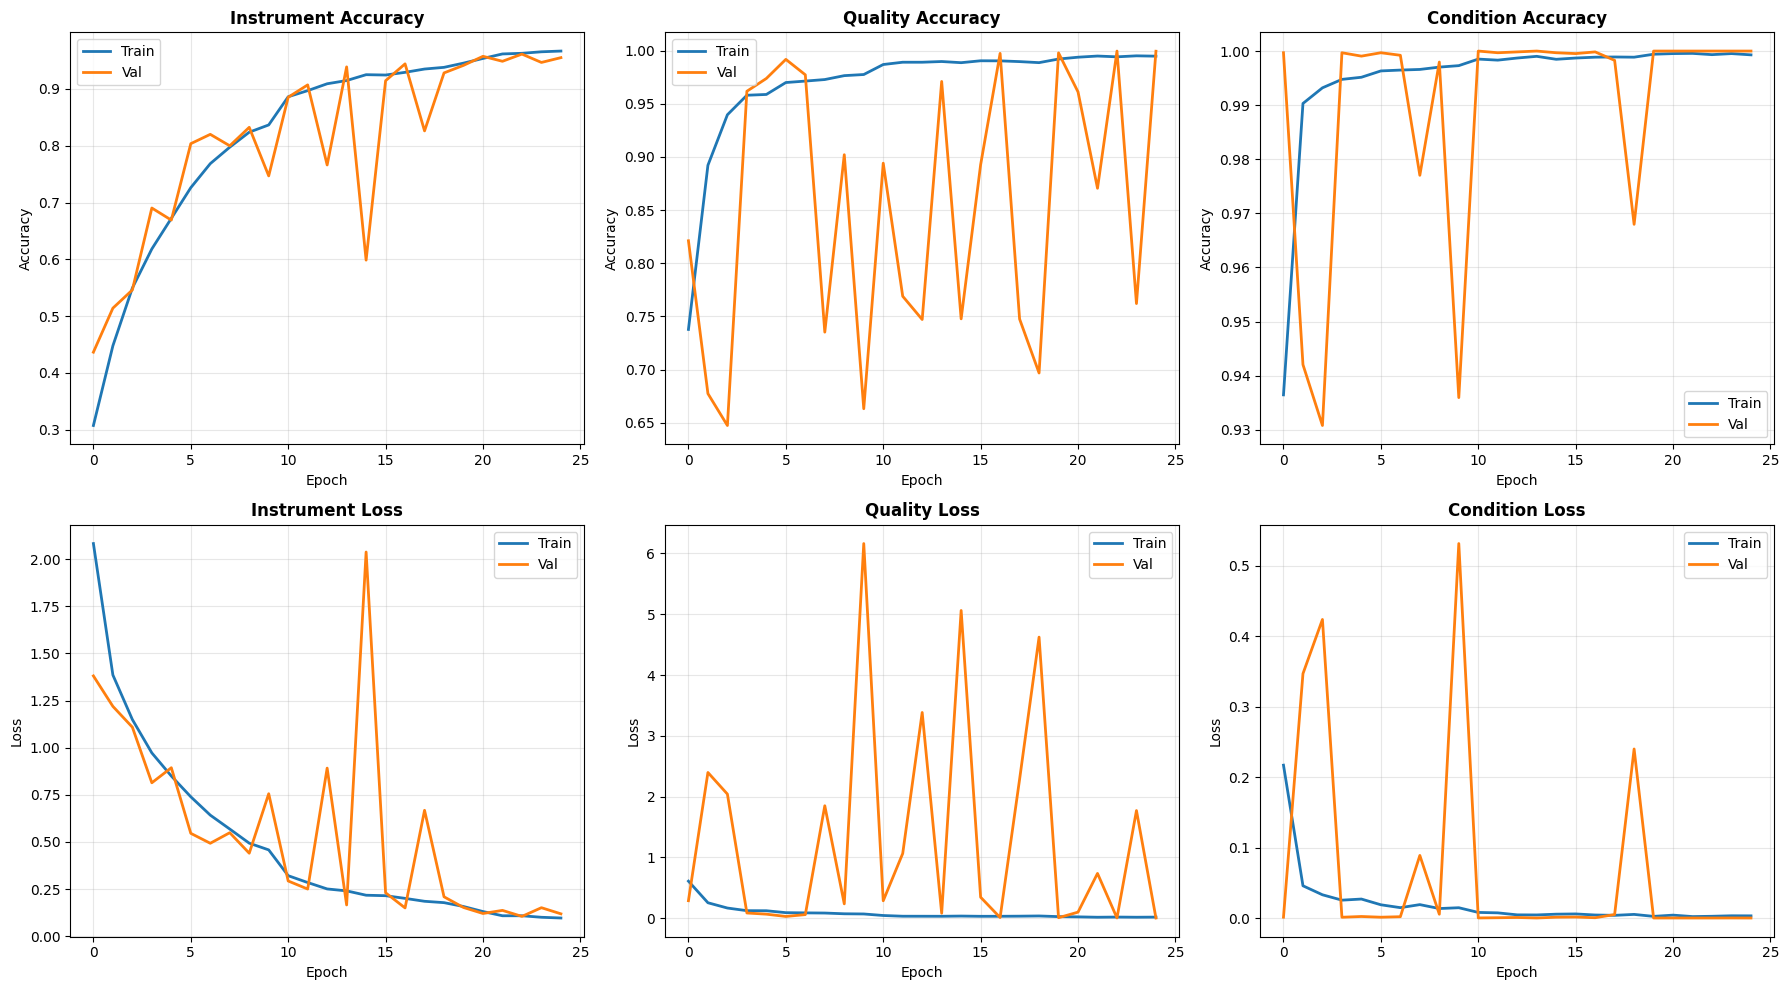

In [ ]:
plot_training_history(history, DRIVE_OUTPUT)

In [ ]:
best_model = keras.models.load_model(os.path.join(DRIVE_OUTPUT, 'best_multitask_model.keras'))
evaluate_model(best_model, X_val, y_inst_val, y_qual_val, y_cond_val, le_inst)


📊 MODEL EVALUATION

🎯 Validation Accuracies:
   Instrument: 96.12%
   Quality: 99.95%
   Condition: 100.00%

📋 Instrument Classification Report:
              precision    recall  f1-score   support

       brass      0.994     0.974     0.984       800
       flute      0.915     0.931     0.923       800
      guitar      0.976     0.966     0.971       800
    keyboard      0.968     0.974     0.971       800
      mallet      0.960     0.963     0.961       800
        reed      0.893     0.915     0.904       800
      string      0.989     0.968     0.978       800
       vocal      1.000     1.000     1.000       800

    accuracy                          0.961      6400
   macro avg      0.962     0.961     0.961      6400
weighted avg      0.962     0.961     0.961      6400


📋 Quality Classification Report:
              precision    recall  f1-score   support

   excellent      1.000     1.000     1.000      1608
        good      0.998     1.000     0.999      1589
      

In [ ]:
def predict_audio(model, audio_file, le_inst):
    """
    Predict instrument, quality, and condition from audio file
    """
    # Load and preprocess
    y, sr = librosa.load(audio_file, sr=22050, duration=3.0, mono=True)

    # Standardize duration
    target_length = int(22050 * 3.0)
    if len(y) < target_length:
        y = np.pad(y, (0, target_length - len(y)), mode='constant')
    else:
        y = y[:target_length]

    # Extract mel-spectrogram
    mel_spec = extract_mel_spectrogram(y, sr)
    mel_spec = mel_spec.reshape(1, 128, 128, 1)

    # Predict
    predictions = model.predict(mel_spec, verbose=0)

    # Decode
    inst_idx = np.argmax(predictions['instrument'][0])
    qual_idx = np.argmax(predictions['quality'][0])
    cond_idx = np.argmax(predictions['condition'][0])

    instrument = le_inst.classes_[inst_idx]
    quality = ['excellent', 'good', 'fair', 'poor'][qual_idx]
    condition = ['modern', 'clean', 'noisy', 'vintage'][cond_idx]

    inst_conf = predictions['instrument'][0][inst_idx] * 100
    qual_conf = predictions['quality'][0][qual_idx] * 100
    cond_conf = predictions['condition'][0][cond_idx] * 100

    # Display results
    print(f"\n{'='*60}")
    print(f"🎵 AUDIO ANALYSIS RESULTS")
    print(f"{'='*60}")
    print(f"📀 Instrument:  {instrument.upper():12s} (Confidence: {inst_conf:.1f}%)")
    print(f"🎚️  Quality:     {quality.upper():12s} (Confidence: {qual_conf:.1f}%)")
    print(f"🔊 Condition:   {condition.upper():12s} (Confidence: {cond_conf:.1f}%)")
    print(f"{'='*60}")

    # Interpretation
    if quality in ['poor', 'fair']:
        print(f"\n💡 Quality Notes:")
        print(f"   • Recording quality is {quality}")
        if condition == 'vintage':
            print(f"   • Audio has vintage/old recording characteristics")
        elif condition == 'noisy':
            print(f"   • Significant background noise detected")

    return {
        'instrument': instrument,
        'quality': quality,
        'condition': condition,
        'confidences': {
            'instrument': inst_conf,
            'quality': qual_conf,
            'condition': cond_conf
        }
    }

In [ ]:
import soundfile as sf

# Step 1: Download NSynth Test Set (to Colab temporary storage)
def download_nsynth_test():
    """Download NSynth test set to /content/ (Colab temp storage)"""
    url = "http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-test.jsonwav.tar.gz"
    output_file = "/content/nsynth-test.jsonwav.tar.gz"
    extract_dir = "/content/nsynth-test"  # ← Colab temp storage (will be deleted)

    if os.path.exists(extract_dir):
        print(f"✅ Test set already exists: {extract_dir}")
        return extract_dir

    print("📥 Downloading NSynth Test Set (~4GB)...")
    print("⏱️  This will take 2-5 minutes...")
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))

    with open(output_file, 'wb') as f, tqdm(
        desc="Downloading",
        total=total_size,
        unit='B',
        unit_scale=True,
        unit_divisor=1024,
    ) as pbar:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
            pbar.update(len(chunk))

    print("✅ Download complete!")
    print("\n📦 Extracting...")
    with tarfile.open(output_file, 'r:gz') as tar:
        tar.extractall(path="/content")

    os.remove(output_file)
    print(f"✅ Extracted to: {extract_dir} (Colab temp)")
    print("🗑️  Archive deleted")
    return extract_dir


# Step 2: Get random test files
def get_test_files(test_dir, num_per_class=5):
    """Get random test files from NSynth test set"""
    json_path = os.path.join(test_dir, "examples.json")
    audio_dir = os.path.join(test_dir, "audio")

    with open(json_path, 'r') as f:
        metadata = json.load(f)

    target_instruments = ['brass', 'flute', 'guitar', 'keyboard',
                         'mallet', 'reed', 'string', 'vocal']

    test_files = {inst: [] for inst in target_instruments}

    for file_id, info in metadata.items():
        if info.get('instrument_source', -1) == 0:  # Acoustic
            family = info.get('instrument_family_str', '')
            if family in target_instruments:
                file_path = os.path.join(audio_dir, f"{file_id}.wav")
                if os.path.exists(file_path):
                    test_files[family].append(file_path)

    # Sample random files
    sampled_files = {}
    for inst, files in test_files.items():
        if len(files) > 0:
            n = min(num_per_class, len(files))
            sampled_files[inst] = np.random.choice(files, n, replace=False).tolist()

    return sampled_files


# Step 3: Save sample audio files to Drive (for UI demo)
def save_sample_audios_for_ui(test_dir, drive_output, samples_per_instrument=2):
    """
    Save diverse sample audio files (original + augmented) to Drive for UI demo.
    Saves samples_per_instrument × 4 variants per instrument.
    """
    print("\n" + "="*80)
    print("💾 SAVING SAMPLE AUDIO FILES TO DRIVE FOR UI DEMO")
    print("="*80)

    # Create samples directory in Drive
    samples_dir = os.path.join(drive_output, 'sample_audio_files')
    os.makedirs(samples_dir, exist_ok=True)

    json_path = os.path.join(test_dir, "examples.json")
    audio_dir = os.path.join(test_dir, "audio")

    with open(json_path, 'r') as f:
        metadata = json.load(f)

    target_instruments = ['brass', 'flute', 'guitar', 'keyboard',
                         'mallet', 'reed', 'string', 'vocal']

    saved_files = []

    for instrument in target_instruments:
        print(f"\n📁 Processing {instrument}...")

        # Find files for this instrument
        instrument_files = []
        for file_id, info in metadata.items():
            if info.get('instrument_source', -1) == 0:
                family = info.get('instrument_family_str', '')
                if family == instrument:
                    file_path = os.path.join(audio_dir, f"{file_id}.wav")
                    if os.path.exists(file_path):
                        instrument_files.append((file_id, file_path))

        if len(instrument_files) == 0:
            print(f"   ⚠️ No files found for {instrument}")
            continue

        # Randomly select files
        np.random.seed(42)  # For reproducibility
        selected = np.random.choice(len(instrument_files),
                                   min(samples_per_instrument, len(instrument_files)),
                                   replace=False)

        for sample_idx, idx in enumerate(selected):
            file_id, src_path = instrument_files[idx]

            # Load audio
            y, sr = librosa.load(src_path, sr=22050, duration=3.0, mono=True)

            # Standardize duration
            target_length = int(22050 * 3.0)
            if len(y) < target_length:
                y = np.pad(y, (0, target_length - len(y)), mode='constant')
            else:
                y = y[:target_length]

            # Create 4 variants (original + 3 augmented)
            variants = create_augmented_variants(y, sr)

            for variant_name, variant_data in variants.items():
                # Create descriptive filename
                output_filename = f"{instrument}_{variant_data['quality']}_{variant_data['condition']}_sample{sample_idx+1}.wav"
                output_path = os.path.join(samples_dir, output_filename)

                # Save audio file to Drive
                sf.write(output_path, variant_data['audio'], sr)

                saved_files.append({
                    'filename': output_filename,
                    'instrument': instrument,
                    'quality': variant_data['quality'],
                    'condition': variant_data['condition'],
                    'path': output_path
                })

                print(f"   ✅ {output_filename}")

    # Save metadata JSON
    metadata_path = os.path.join(samples_dir, 'samples_metadata.json')
    with open(metadata_path, 'w') as f:
        json.dump(saved_files, f, indent=2)

    print(f"\n✅ Saved {len(saved_files)} sample audio files!")
    print(f"📂 Drive Location: {samples_dir}")
    print(f"📋 Metadata: {metadata_path}")

    # Summary
    print(f"\n📊 Summary:")
    for instrument in target_instruments:
        count = sum(1 for s in saved_files if s['instrument'] == instrument)
        if count > 0:
            print(f"   {instrument:12s}: {count} files (original + augmented)")

    return samples_dir, saved_files


# Step 4: Test model on NSynth test files
def test_on_nsynth(test_files, model, le_inst):
    """Test model on NSynth test set"""
    print("\n" + "="*80)
    print("🧪 TESTING ON NSYNTH TEST SET")
    print("="*80)

    total_correct = 0
    total_tested = 0

    results_by_instrument = {}

    for instrument, files in test_files.items():
        print(f"\n{'='*80}")
        print(f"Testing {instrument.upper()} ({len(files)} samples)")
        print(f"{'='*80}")

        correct = 0

        for file_path in files:
            print(f"\n📁 File: {os.path.basename(file_path)}")
            result = predict_audio(model, file_path, le_inst)

            # Check if correct
            if result['instrument'].lower() == instrument.lower():
                print("✅ CORRECT INSTRUMENT!")
                correct += 1
                total_correct += 1
            else:
                print(f"❌ WRONG! Expected: {instrument.upper()}")

            total_tested += 1

        accuracy = (correct / len(files)) * 100 if len(files) > 0 else 0
        results_by_instrument[instrument] = {
            'correct': correct,
            'total': len(files),
            'accuracy': accuracy
        }

        print(f"\n{instrument.upper()} Accuracy: {correct}/{len(files)} = {accuracy:.1f}%")

    # Overall summary
    print("\n" + "="*80)
    print("📊 OVERALL TEST RESULTS")
    print("="*80)
    print(f"\nTotal Accuracy: {total_correct}/{total_tested} = {(total_correct/total_tested)*100:.1f}%")
    print(f"\nPer-Instrument Breakdown:")
    for inst, res in results_by_instrument.items():
        print(f"   {inst:12s}: {res['correct']:2d}/{res['total']:2d} = {res['accuracy']:5.1f}%")

    return results_by_instrument


# Step 5: Quick test on saved samples
def test_saved_samples(saved_files, model, le_inst, num_samples=5):
    """Quick test on saved sample files"""
    print("\n" + "="*80)
    print("🧪 TESTING SAVED SAMPLE FILES")
    print("="*80)

    # Test random samples
    test_samples = np.random.choice(saved_files, min(num_samples, len(saved_files)), replace=False)

    correct_inst = 0
    correct_qual = 0
    correct_cond = 0

    for sample in test_samples:
        print(f"\n{'='*60}")
        print(f"Testing: {sample['filename']}")
        print(f"Expected: {sample['instrument']} | {sample['quality']} | {sample['condition']}")
        print(f"{'='*60}")

        result = predict_audio(model, sample['path'], le_inst)

        # Check correctness
        inst_match = result['instrument'].lower() == sample['instrument'].lower()
        qual_match = result['quality'].lower() == sample['quality'].lower()
        cond_match = result['condition'].lower() == sample['condition'].lower()

        if inst_match:
            correct_inst += 1
        if qual_match:
            correct_qual += 1
        if cond_match:
            correct_cond += 1

        print(f"\n✅ Results:")
        print(f"   Instrument: {'✅ CORRECT' if inst_match else '❌ WRONG'}")
        print(f"   Quality:    {'✅ CORRECT' if qual_match else '❌ WRONG'}")
        print(f"   Condition:  {'✅ CORRECT' if cond_match else '❌ WRONG'}")

    print(f"\n📊 Saved Samples Accuracy:")
    print(f"   Instrument: {correct_inst}/{num_samples} = {(correct_inst/num_samples)*100:.1f}%")
    print(f"   Quality:    {correct_qual}/{num_samples} = {(correct_qual/num_samples)*100:.1f}%")
    print(f"   Condition:  {correct_cond}/{num_samples} = {(correct_cond/num_samples)*100:.1f}%")


# Step 6: Cleanup NSynth test set
def cleanup_nsynth_test(test_dir):
    """Delete NSynth test set from Colab to free space"""
    if os.path.exists(test_dir):
        print(f"\n🗑️  Deleting NSynth test set: {test_dir}")
        print("⏳ This will take 1-2 minutes...")
        shutil.rmtree(test_dir)
        print(f"✅ Deleted! Freed ~4 GB in Colab")
        print(f"💾 Sample audio files are safe in Google Drive")
    else:
        print(f"⚠️  Directory not found: {test_dir}")


# ===================================================================================
# EXECUTE COMPLETE TESTING PIPELINE
# ===================================================================================

print("\n" + "="*80)
print("🎯 COMPLETE TESTING & SAMPLE SAVING PIPELINE")
print("="*80)

# 1. Download NSynth test set (to Colab)
test_dir = download_nsynth_test()

# 2. Get test files for evaluation
test_files = get_test_files(test_dir, num_per_class=5)

# 3. Test model on NSynth test set
test_results = test_on_nsynth(test_files, best_model, le_inst)

# 4. Save sample audio files to Drive (for UI demo)
samples_dir, saved_files = save_sample_audios_for_ui(
    test_dir,
    DRIVE_OUTPUT,
    samples_per_instrument=2  # 2 samples × 4 variants = 8 files per instrument
)

# 5. Test the saved samples
test_saved_samples(saved_files, best_model, le_inst, num_samples=10)

# 6. Cleanup NSynth test set (free Colab space)
cleanup_nsynth_test(test_dir)

# Final summary
print("\n" + "="*80)
print("✅ COMPLETE PIPELINE FINISHED!")
print("="*80)
print(f"\n📂 Files in Google Drive:")
print(f"   Model: {DRIVE_OUTPUT}/best_multitask_model.keras")
print(f"   Samples: {samples_dir}/ ({len(saved_files)} audio files)")
print(f"   Metadata: {samples_dir}/samples_metadata.json")
print(f"\n💡 For UI Demo:")
print(f"   1. Download samples from: {samples_dir}/")
print(f"   2. Upload to UI to test predictions")
print(f"   3. Show different quality/condition predictions")
print("="*80)


🎯 COMPLETE TESTING & SAMPLE SAVING PIPELINE
✅ Test set already exists: /content/nsynth-test

🧪 TESTING ON NSYNTH TEST SET

Testing BRASS (5 samples)

📁 File: brass_acoustic_015-047-100.wav

🎵 AUDIO ANALYSIS RESULTS
📀 Instrument:  BRASS        (Confidence: 100.0%)
🎚️  Quality:     EXCELLENT    (Confidence: 100.0%)
🔊 Condition:   MODERN       (Confidence: 100.0%)
✅ CORRECT INSTRUMENT!

📁 File: brass_acoustic_006-079-127.wav

🎵 AUDIO ANALYSIS RESULTS
📀 Instrument:  BRASS        (Confidence: 100.0%)
🎚️  Quality:     EXCELLENT    (Confidence: 100.0%)
🔊 Condition:   MODERN       (Confidence: 100.0%)
✅ CORRECT INSTRUMENT!

📁 File: brass_acoustic_046-097-127.wav

🎵 AUDIO ANALYSIS RESULTS
📀 Instrument:  GUITAR       (Confidence: 49.3%)
🎚️  Quality:     EXCELLENT    (Confidence: 100.0%)
🔊 Condition:   MODERN       (Confidence: 100.0%)
❌ WRONG! Expected: BRASS

📁 File: brass_acoustic_006-087-100.wav

🎵 AUDIO ANALYSIS RESULTS
📀 Instrument:  BRASS        (Confidence: 100.0%)
🎚️  Quality:     EXCEL